# Projet de modélisation d'un mix énergétique issu 100% d'ENR

## XIV. Modelling new production profils

### Imports

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from opti_model import opti_model

In [3]:
from typical_days import Profils_vre_datetime, Mean_std_profil_18, Array_mean_std, New_Array_mean_std, Clustering_days, Index_centers, Typical_days, Typical_year, Labels_new_year, Typical_new_year, distanceMetric, ans, Import_data
from modelling_new_year import Decomposition, Simulate_Noise

In [4]:
def simulating_new_year():

    year = np.random.randint(0,18,1)
    print("Year " + str(2000+year))
    profils_off, profils_on, profils_pv = Profils_vre_datetime()

    for vre in ['pv', 'onshore', 'offshore']:

        if vre == 'pv':
            profils = profils_pv
        elif vre == 'onshore':
            profils = profils_on
        else:
            profils = profils_off

        day_mean_18, p18 = Mean_std_profil_18(profils)
        day_std_18, _ = Mean_std_profil_18(profils, False)

        trend_mean, seasonal_mean, residual_mean = Decomposition(day_mean_18, False)
        new_mean = Simulate_Noise(trend_mean, seasonal_mean, residual_mean, day_mean_18, False)
        trend_std, seasonal_std, residual_std = Decomposition(day_std_18, False)
        new_std = Simulate_Noise(trend_std, seasonal_std, residual_std, day_std_18, False)

        new_daily_mean = new_mean[365*year[0]:365*(year[0]+1)]
        new_daily_std = new_std[365*year[0]:365*(year[0]+1)]
        new_array = New_Array_mean_std(new_daily_mean, new_daily_std)

        #Profils de production moyenne et variance sur le dataset entier
        array = Array_mean_std(day_mean_18, day_std_18)

        #KMedoids clustering
        n_clusters = 12
        centers_existing_data, labels_existing_data = Clustering_days(array, n_clusters, metric='euclidean', verbose_plot=False)  
        centers, labels, new_labels = Labels_new_year(array, new_array, n_clusters, 'euclidean', False)

        #New year
        typical_year = Typical_new_year(n_clusters, centers, labels, new_labels, array, p18)
        
        if vre == 'onshore':
            typical_year_on = pd.DataFrame(typical_year)
        elif vre == 'offshore':
            typical_year_off = pd.DataFrame(typical_year)
        else:
            typical_year_pv = pd.DataFrame(typical_year)
        
    return typical_year_off, typical_year_on, typical_year_pv

In [5]:
def save_new_profile(typical_year_off, typical_year_on, typical_year_pv):
    vre2006 = pd.read_csv("inputs/vre_profiles2006.csv", header=None)
    vrenew = pd.DataFrame()
    vrenew = vre2006.copy()

    typical_year_pv = pd.DataFrame(typical_year_pv)
    typical_year_on = pd.DataFrame(typical_year_on)
    typical_year_off = pd.DataFrame(typical_year_off)

    vrenew[2].iloc[:8760] = typical_year_off[0]
    vrenew[2].iloc[8760:17520] = typical_year_on[0]
    vrenew[2].iloc[17520:] = typical_year_pv[0]
    
    return vrenew

In [6]:
def opti_simu(Q_tec, Volume_str, S, nb_simu = 30):
    for simu in range(nb_simu):
        model_name = "vrenew"+str(simu)
        
        #New weather year
        typical_year_off, typical_year_on, typical_year_pv = simulating_new_year()
        vrenew = save_new_profile(typical_year_off, typical_year_on, typical_year_pv)
        
        vrenew.to_csv('inputs/'+ model_name +'.csv', header=None, index=False)
        
        #Simulation modèle optimal (on fixe les capacités)
        simu0 = opti_model(Q_tec, Volume_str, S)
        simu0.load_param("inputs/", model_name+".csv", "demand2050_rte.csv")
        simu0.run()
        
        res0 = simu0.write_results("simu"+model_name+'.csv', model_name+".csv", "demand2050_rte.csv")

In [7]:
col = {"offshore" : '#1f4e79', "onshore" : '#548235' , "pv" : "#ffc000", "phs" : "#bdd7ee", "battery" : "#7030a0", "biogas" :"#843c0c", "methanation": "#7f6000", "gas": "grey", "lake": "#4169E1", "river" : "#09F1D3"}
tec = ["offshore","onshore","pv","river","lake","biogas","phs","battery","methanation"]
stor = ["phs","battery","methanation"]

In [15]:
# Optimal values found in summary with demand of RTE and vre 2006
Volume_str_opti = pd.Series([135.5, 186.77956, 14356.455], index = stor)
S_opti = pd.Series([6.2,33.875077, 10.991424], index = stor)
Q_tec_opti = pd.Series([20, 120, 153.59165, 7.5, 12.855 ,37.009384, 6.3936009, 33.875077, 10.828085], index = tec)
Cost_opti = 29.214222756075717 

opti_simu(Q_tec_opti, Volume_str_opti, S_opti, nb_simu = 30)

Year [2007]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew0.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2015]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew1.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2005]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew2.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2013]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew3.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2003]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew4.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2002]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew5.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2016]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew6.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2007]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew7.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2012]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew8.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2006]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew9.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2001]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew10.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2013]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew11.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2005]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew12.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2001]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew13.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2014]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew14.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2014]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew15.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2005]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew16.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2000]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew17.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2005]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew18.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2000]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew19.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2000]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew20.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2006]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew21.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2000]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew22.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2003]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew23.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2009]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew24.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2014]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew25.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2014]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew26.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2008]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew27.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2002]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew28.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


Year [2004]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Technologies utilisées : ['offshore', 'onshore', 'pv', 'river', 'lake', 'biogas', 'phs', 'battery', 'methanation']
Chargement des paramètres ...
vrenew29.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\internals\construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


30


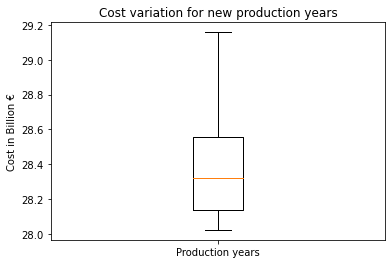

In [37]:
list_cost = []
for simu in range(30):
    model_name = "simuvrenew"+str(simu)+".csv"
    cost = pd.read_csv("simulations/new_simulations/"+model_name+"/"+model_name+"_Cost.csv", names=['vre', 'cost'])
    list_cost += [float(cost['cost'][1][73:82])]
print(len(list_cost))
plt.boxplot(list_cost)
plt.ylabel('Cost in Billion €')
plt.xticks([1], ['Production years'])
plt.title('Cost variation for new production years')
plt.show()

In [62]:
from complete_model import complete_model

def complete_simu(nb_simu = 30):
    for simu in range(nb_simu):
        model_name = "vrenew"+str(simu)
        
        #New weather year
        typical_year_off, typical_year_on, typical_year_pv = simulating_new_year()
        vrenew = save_new_profile(typical_year_off, typical_year_on, typical_year_pv)
        
        vrenew.to_csv('inputs/'+ model_name +'.csv', header=None, index=False)
        
        #Simulation modèle optimal (on fixe les capacités)
        simu0 = complete_model()
        simu0.load_param("inputs/", model_name+".csv", "demand2050_rte.csv")
        simu0.run()
        
        res0 = simu0.write_results("simu"+model_name+'.csv', model_name+".csv", "demand2050_rte.csv")

In [63]:
complete_simu()

Year [2004]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew0.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2010]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew1.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2014]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew2.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2012]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew3.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2011]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew4.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2013]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew5.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2001]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew6.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2002]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew7.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2008]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew8.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2014]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew9.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2001]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew10.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2007]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew11.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2016]


C:\Users\teaca\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Chargement des paramètres ...
vrenew12.csv
demand2050_rte.csv
Initialisation des sets...
Définition des variables à optimiser ...
Ajout des contraintes ...
Optimisation ...
Simulation du modèle faite avec succès ! 
Ecriture des résultats ...
Year [2017]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

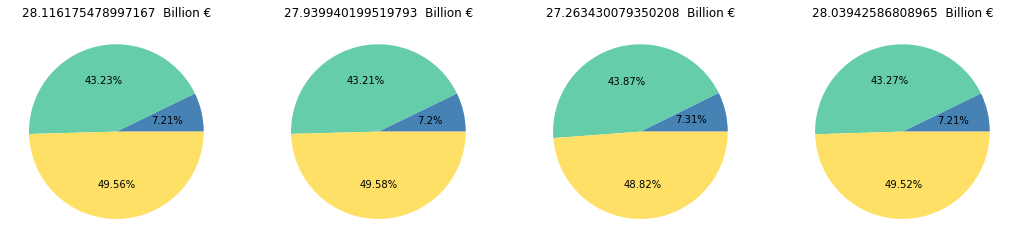

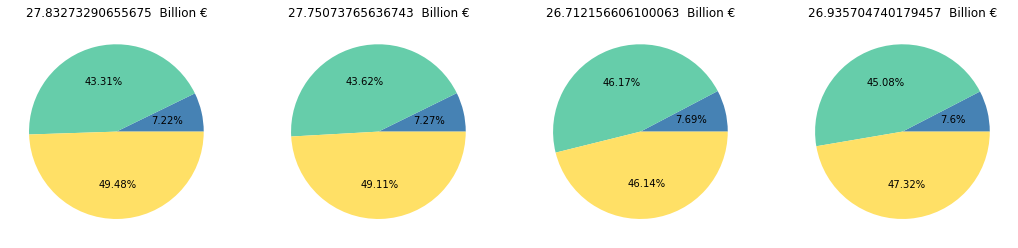

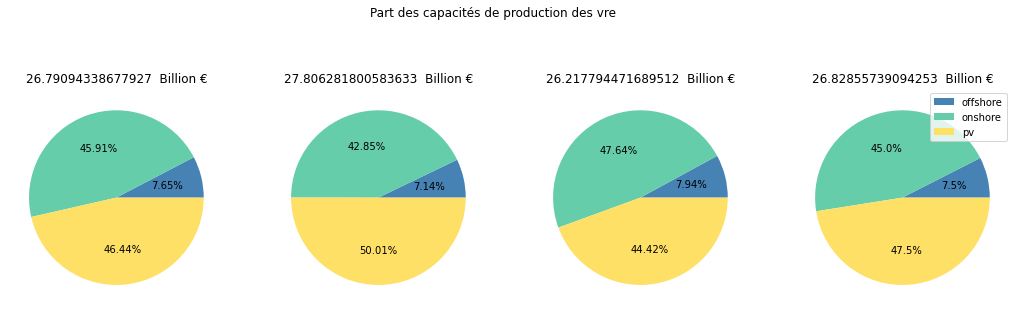

In [40]:
colors = ["steelblue", "Mediumaquamarine", "#FFE066", "slateblue", "#FFD8A8", "Lightslategray", "grey", "#09F1D3", "#74C0FC"]

fig, axs = plt.subplots(1,4, figsize=(18,18))
fig2, axs2 = plt.subplots(1,4, figsize=(18,18))
fig3, axs3 = plt.subplots(1,4, figsize=(18,18))

list_cost = []
list_capa = []

for i in range(12):
    name_load_factor = "simuvrenew"+str(i)+".csv"
    cost = pd.read_csv("simulations/new_complete_simulations/"+name_load_factor+"/"+name_load_factor+"_Cost.csv", names=['vre', 'cost'])
    capa = pd.read_csv("simulations/new_complete_simulations/"+name_load_factor+"/"+name_load_factor+"_Q.csv", names=['vre', 'capa'])

    y = np.array([capa["capa"][1], capa["capa"][2], capa["capa"][3]])
    cost = float(cost['vre'][0])
    
    list_cost += [cost]
    list_capa += [y]
    
    if i < 4:
        wedges, texts, autotexts = axs[i].pie(y, autopct = lambda y: str(round(y, 2)) + '%', colors=colors)
        axs[i].set_title(str(cost) + "  Billion €")
    elif i>=4 and i<8:
        wedges, texts, autotexts = axs2[i-4].pie(y, autopct = lambda y: str(round(y, 2)) + '%', colors=colors)
        axs2[i-4].set_title(str(cost) + "  Billion €")
    else:
        wedges, texts, autotexts = axs3[i-8].pie(y, autopct = lambda y: str(round(y, 2)) + '%', colors=colors)
        axs3[i-8].set_title(str(cost) + "  Billion €")
        
    
axs3[i-8].legend(wedges, ["offshore", "onshore", "pv"])

plt.suptitle("Part des capacités de production des vre", y=0.65)
plt.show()

plt.show()

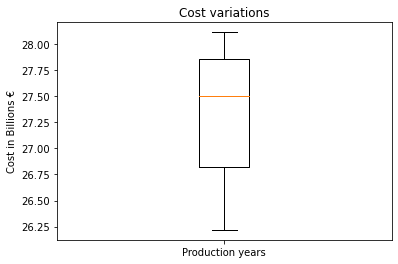

In [41]:
plt.boxplot(list_cost)
plt.title('Cost variations')
plt.ylabel('Cost in Billions €')
plt.xticks([1], ['Production years'])
plt.show()

In [20]:
list_capa[:,0]

array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.])

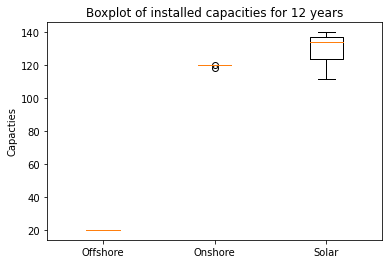

In [34]:
list_capa = np.array(list_capa)
plt.boxplot(list_capa)
plt.title('Boxplot of installed capacities for 12 years')
plt.xticks([1, 2, 3], ['Offshore', 'Onshore', 'Solar'])
plt.ylabel('Capacties')
plt.show()